In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse

The goal of this notebook is to solve the inverse problem 

$$
y = Ax + n \ ,
$$

where $A$ is linear forward operator encoding a blur/convolution operation, $n$ is some additive noise with $n \sim \mathcal{N} (0, \sigma^2 I) $ and $y$ is the blurry observation of $y$.

**Goal:** Retrieve $x$ from $y$.

**Problem position:**

- *Likelihood:* Gaussian with density $\pi_{Y|X=x}(y) \propto \exp (- \frac{1}{2\sigma^2} \| Ax - y\|_2^2)$.
- *Prior:* $\pi_X (x)$ of natural images.

Applying Bayes's rule, we can define a posterior distribution with density $\pi_{X|Y=y}(x) \propto \pi_X(x) \pi_{Y|X=x}(y)$.

**Implicit prior defined by Gaussian convolution:** 

We do not have access to $\pi_X$. Let us consider a smooth version of $\pi_X$ resulting from the convolution between $\pi_X$ and a Gaussian kernel $g_\alpha$ with zero mean and $\alpha I$ covariance matrix. We denote it $\pi_X^\alpha$ and define it as follows 

$$
\forall x_\alpha \in \mathbb{R}^d, \ \pi_X^{\alpha} (x_\alpha) = (\pi_X * g_\alpha )(x_\alpha) = \int_{\mathbb{R}^d} \pi_X(x) g_\alpha (x_\alpha-x)dx = \int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / Z \ ,
$$

with $Z$ the normalization constant.

*Remark:* As long as we don't have access to $\pi_X$, we cannot compute $\pi_X^\alpha$. Furthermore, even if we had access to $\pi_X$, computing $\pi_X^\alpha(x)$ would require to estimate a high-dimensional integral which is not doable in practice.

*Remark:* According to the definition of $\pi_X^\alpha$, we have $X_\alpha = X + \sqrt{\alpha} B$ with $B \sim \mathcal{N}(0, I)$. 

$\forall x_\alpha \in \mathbb{R}^d$, we have

\begin{align}
    \nabla_x \log \pi_X^\alpha(x_\alpha) &= \nabla_x [\pi_X^\alpha (x_\alpha)]/\pi_X^\alpha (x_\alpha) \\
    &= \nabla_x [\int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx] /\pi_X^\alpha (x_\alpha) \\
    &= \int_{\mathbb{R}^d} \nabla_x [\pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha)] dx /\pi_X^\alpha (x_\alpha) \\
    &= -\int_{\mathbb{R}^d} \pi_X(X) (x_\alpha-x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx /\alpha \pi_X^\alpha (x_\alpha) \\
    &= \frac{1}{\alpha}[\int_{\mathbb{R}^d} x \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha) - x_\alpha \int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha)] \\
    &= \frac{1}{\alpha} [\int_{\mathbb{R}^d} x \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha) - x_\alpha ] \\
    &= \frac{1}{\alpha} [ \mathbb{E}_{\pi_{X|X_\alpha = x_\alpha}}[X|X_\alpha=x_\alpha] - x_\alpha ]
\end{align}

Then, to compute $\nabla \log \pi_X^\alpha$, we need to estimate the MMSE for the denoising inverse problem $X_\alpha = X + \alpha B $, ie $\mathbb{E}[X|X_\alpha=x_\alpha]$.

Consequently, the smoothed prior $\pi_X^\alpha$ is only defined via a MMSE denoising algorithm. Knowing this quantity we can apply any gradient based algorithm involving $\nabla \log \pi_X^\alpha$.  

# Imports

In [2]:
import numpy as np
from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian
from cuqi.problem import BayesianProblem

# Inverse problem definition

In [3]:
A, y_obs, info=Deconvolution2D().get_components()

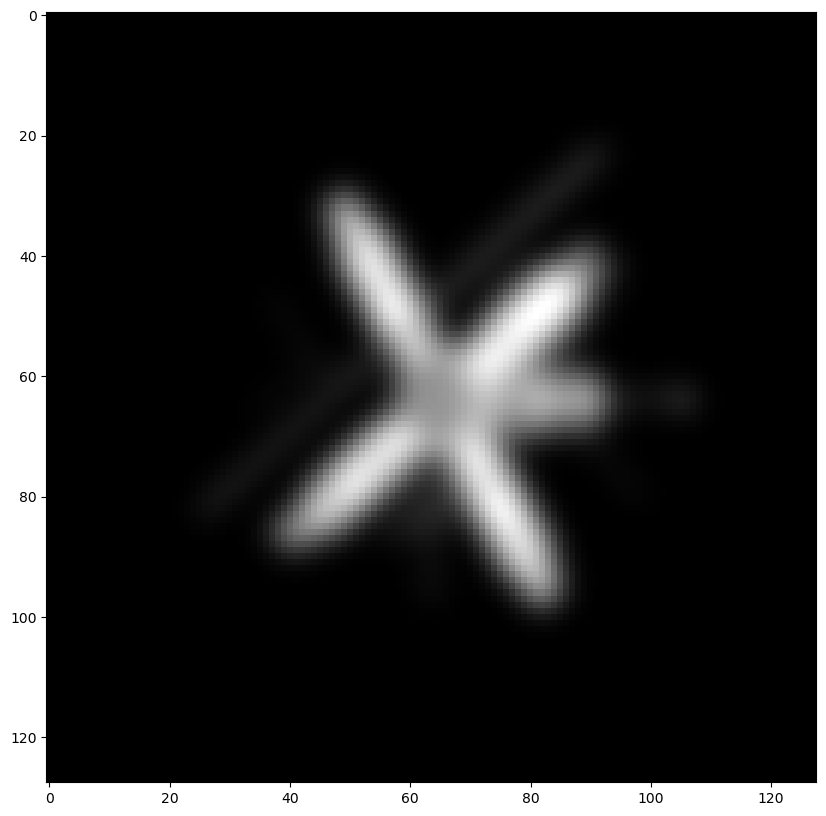

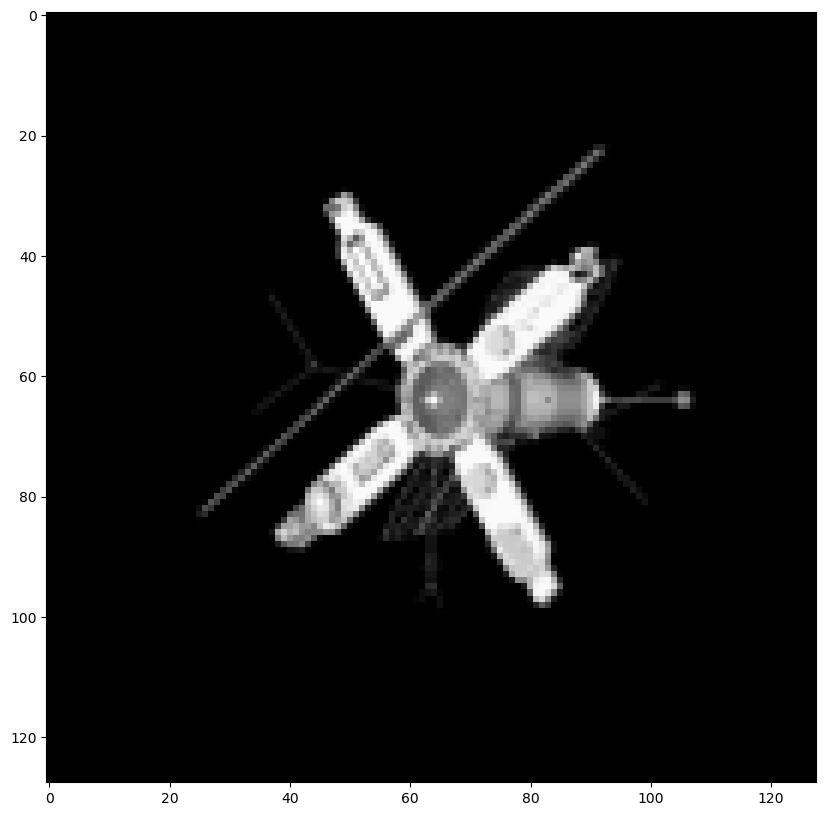

In [4]:
plt.figure(figsize=(10, 10))
y_obs.plot()
plt.figure(figsize=(10, 10))
info.exactSolution.plot()

In [5]:
y=Gaussian(mean=A, cov=0.01)

In [6]:
likelihood=y(y=y_obs)

In [14]:
#%% Denoiser definition
from skimage.restoration import denoise_nl_means
from skimage.metrics import mean_squared_error as mse

k=0.8
strength_smooth=k*np.sqrt(0.01)
N=int(np.sqrt(info.exactSolution.shape[0]))
def denoiser(x):
    out=denoise_nl_means(np.reshape(x, (N, N)), patch_size=5, patch_distance=10, h=1, fast_mode=True, sigma=strength_smooth)
    return out.flatten()

#%% Gradient prior
gradient_prior = lambda x : (denoiser(x) - x)/strength_smooth

# PnP-GD

In this section we only perform optimization. The goal is to estimate $x_{MAP}$ defined as follows

\begin{align}
x_{MAP} &= \operatorname{argmax}_u \pi_{Y|X=u} (y) \ \pi_X^\alpha(u) \\
&= \operatorname{argmax}_u  \log \pi_{Y|X=u} (y) + \log \pi_X^\alpha(u) \\
&= \operatorname{argmin}_u - \log \pi_{Y|X=u} (y) - \log \pi_X^\alpha(u) \\
&= \operatorname{argmin}_u \|Au-y \|_2^2/2\sigma^2 - \log \pi_X^\alpha(u)
\end{align}

To solve this optimization problem we are going to apply the deterministic gradient algorithm which reads as follows

\begin{align}
    x_{k+1} &= x_k + \delta \nabla \log \pi_{Y|X=x_k} (y) + \delta \nabla \log \pi_X^\alpha (x_k) ,  \\
    &= x_k + \delta \nabla \log \pi_{Y|X=x_k} (y) + \delta (D_\alpha(x_k) -x_k)/\alpha
\end{align}

We let run the GD algorithm for $Ns=5000$.

At iteration  1000 mse(info.ExactSolution, Xk) =  27.628960516357992
At iteration  2000 mse(info.ExactSolution, Xk) =  25.776266877753656
At iteration  3000 mse(info.ExactSolution, Xk) =  24.697207944282866
At iteration  4000 mse(info.ExactSolution, Xk) =  23.934113601929983
At iteration  5000 mse(info.ExactSolution, Xk) =  23.33741426087102


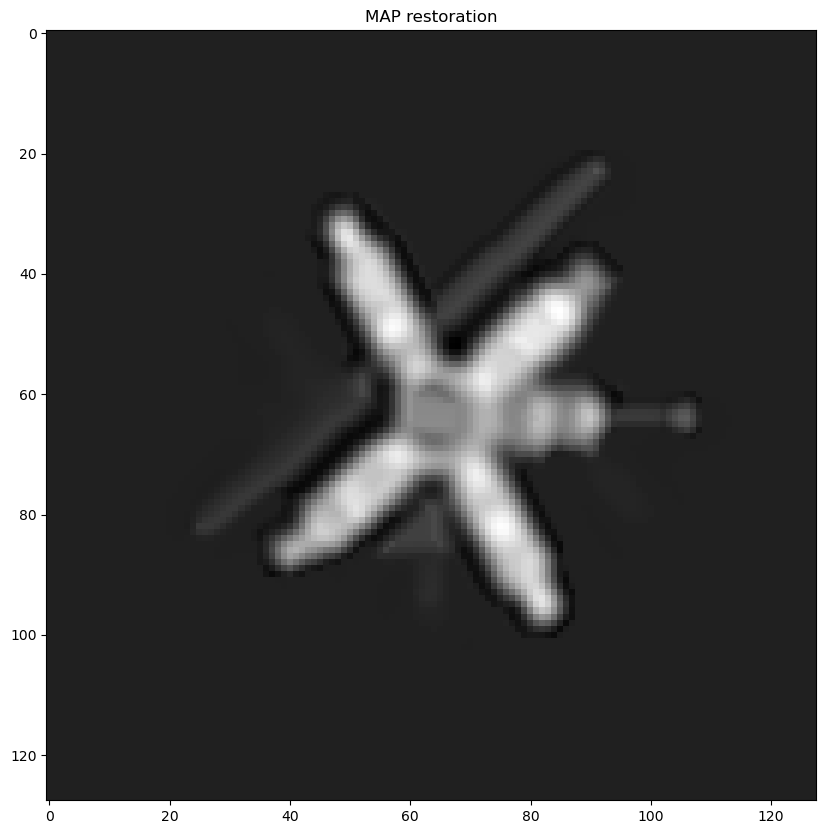

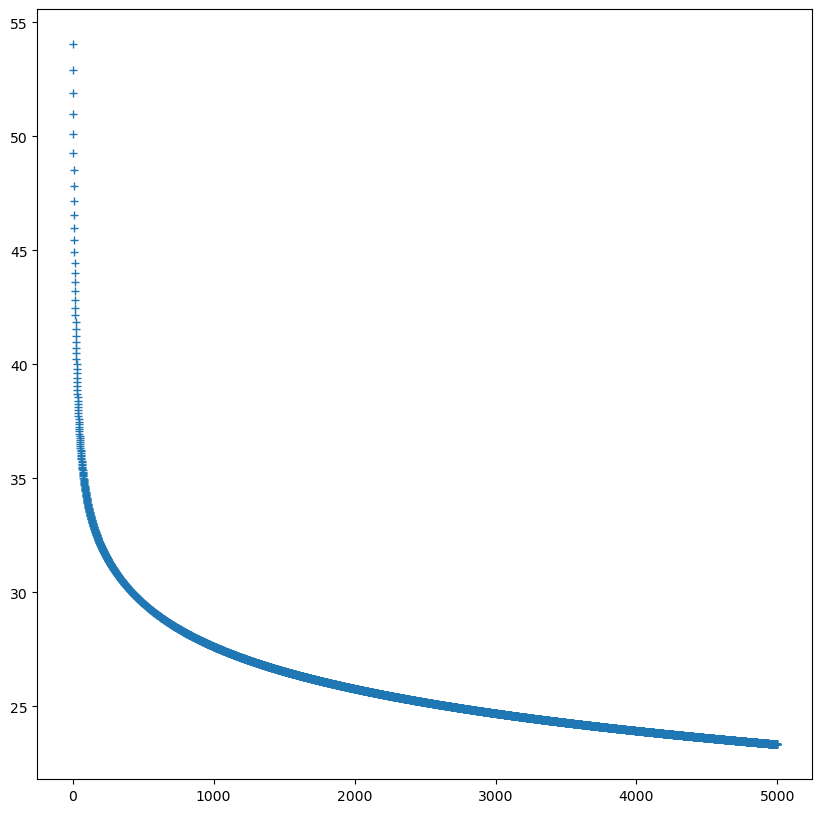

In [7]:
#%% PnP-GD parameters
scale=0.001
Ns=5000

#%% GD-algorithm
MSE=[]
Xk=np.copy(y_obs)
for i in range(Ns):
    Zk=np.random.normal(0,1,info.exactSolution.shape)
    Xk=Xk + scale*likelihood.gradient(Xk) + scale*gradient_prior(Xk) #+ np.sqrt(2*scale)*Z
    if (i+1)%1000==0:
        print("At iteration ", i + 1, "mse(info.ExactSolution, Xk) = ", mse(info.exactSolution, Xk))
    MSE.append(mse(info.exactSolution, Xk))
map=np.copy(Xk)
map=np.reshape(map, (N,N))
plt.figure(figsize=(10, 10))
plt.imshow(map, cmap="gray")
plt.title('MAP restoration')

plt.figure(figsize=(10, 10))
plt.plot(MSE, "+")

# Sampling with PnP-ULA

In this section, we aim at sampling from the target density $\pi_{X|Y=y}^\alpha(x) \propto \pi_{Y|X=x}(y) \pi_X^\alpha (x)$ which is an approximation of $\pi_{X|Y=y}(x)$

We apply (PnP)-ULA which reads as follows

\begin{align}
        x_{k+1} &= x_k + \delta \nabla \log \pi_{Y|X=x_k} (y) + \delta \nabla \log \pi_X^\alpha (x_k) + \sqrt{2\delta} z_{k+1} ,  \\
    &= x_k + \delta \nabla \log \pi_{Y|X=x_k} (y) + \delta (D_\alpha(x_k) -x_k)/\alpha + \sqrt{2\delta} z_{k+1} \  ,
\end{align}

$z_{k+1} \sim \mathcal{N}(0, I)$.

We let PnP-ULA for $Nsampling = 20000$ iterations.

Text(0.5, 1.0, 'MMSE restoration')

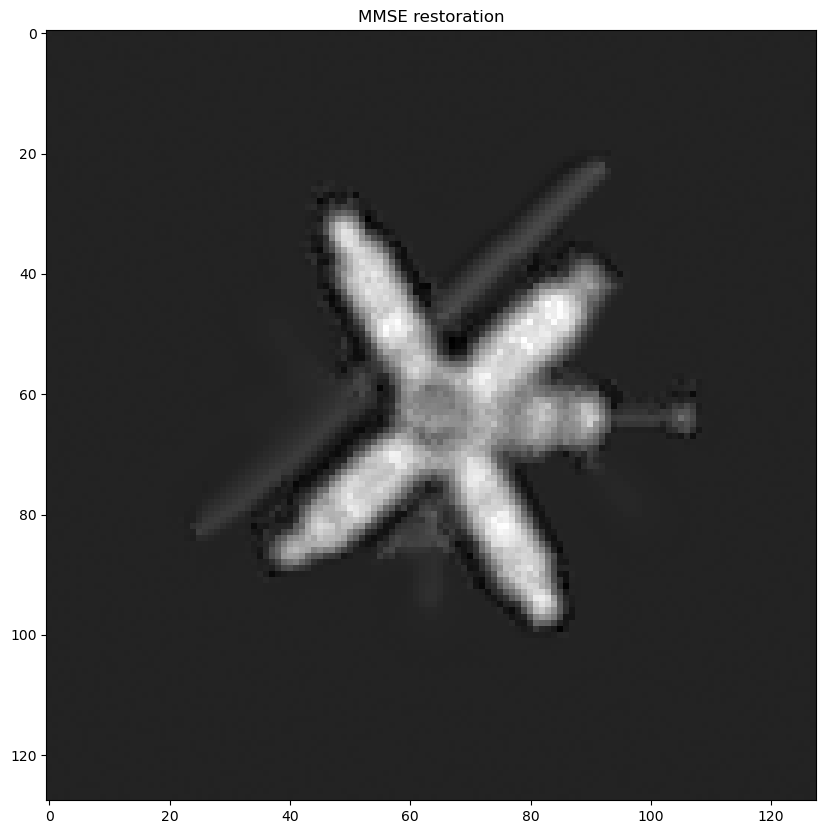

In [9]:
#%% PnP-ULA-algorithm
Nsampling=20000
Xk=np.copy(y_obs)
Samples=[]
for i in range(Nsampling):
    Zk=np.random.normal(0,1,info.exactSolution.shape)
    Xk=Xk + scale*likelihood.gradient(Xk) + scale*gradient_prior(Xk) + np.sqrt(2*scale)*Zk
    Samples.append(Xk)
mean=np.mean(Samples, axis=0)
mean=np.reshape(mean, (N, N))
plt.figure(figsize=(10, 10))
plt.imshow(mean, cmap="gray")
plt.title('MMSE restoration')

In [10]:
print("MSE(info.exactSolution, map) = ", mse(info.exactSolution, map.flatten()))
print("MSE(info.exactSolution, mean) = ", mse(info.exactSolution, mean.flatten()))

MSE(info.exactSolution, map) =  23.33741426087102
MSE(info.exactSolution, mean) =  23.04787246348297


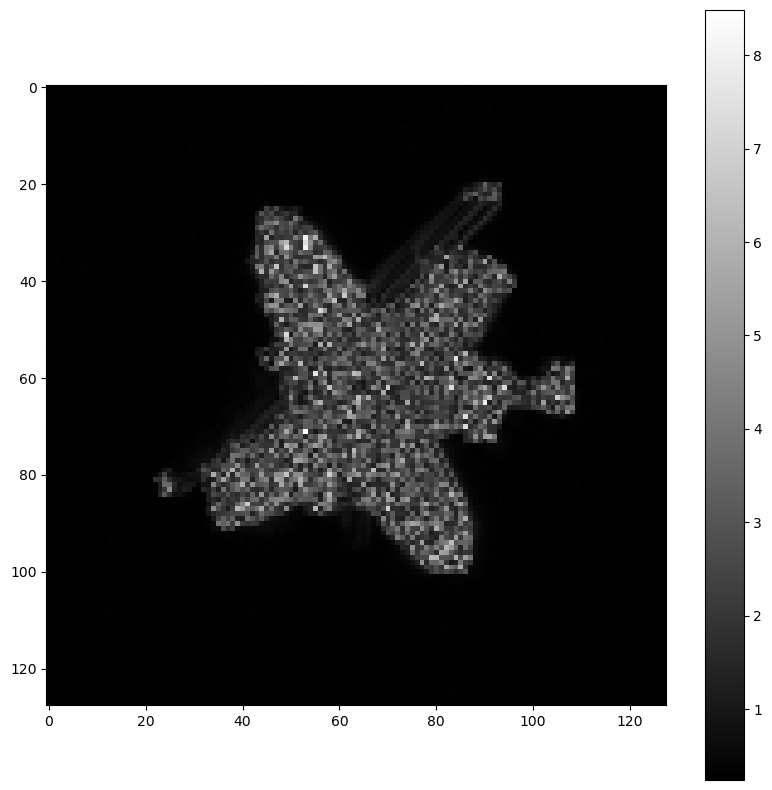

In [12]:
std = np.std(Samples, axis = 0)
plt.figure(figsize = (10, 10))
plt.imshow(np.reshape(std, (N,N)), cmap="gray")
plt.colorbar()

# PnP-RTO

In this section we aim at sampling from 

\begin{align}
    \mathbb{\hat{y}} &\sim \mathcal{N}(y, \sigma^2 I) \\
    x &=\operatorname{argmax}_u \log \pi_{Y|X=u}(\hat{y}) + \log \pi_X^\alpha (u)
\end{align}

We generate $Nrto=10$ samples. To generate one sample, we solve $(2)$ by applying the GD algorithm for $2000$ iterations.

0
1
2
3
4
5
6
7
8
9
MSE(info.exactSolution, mean_rto) =  25.776678801943426


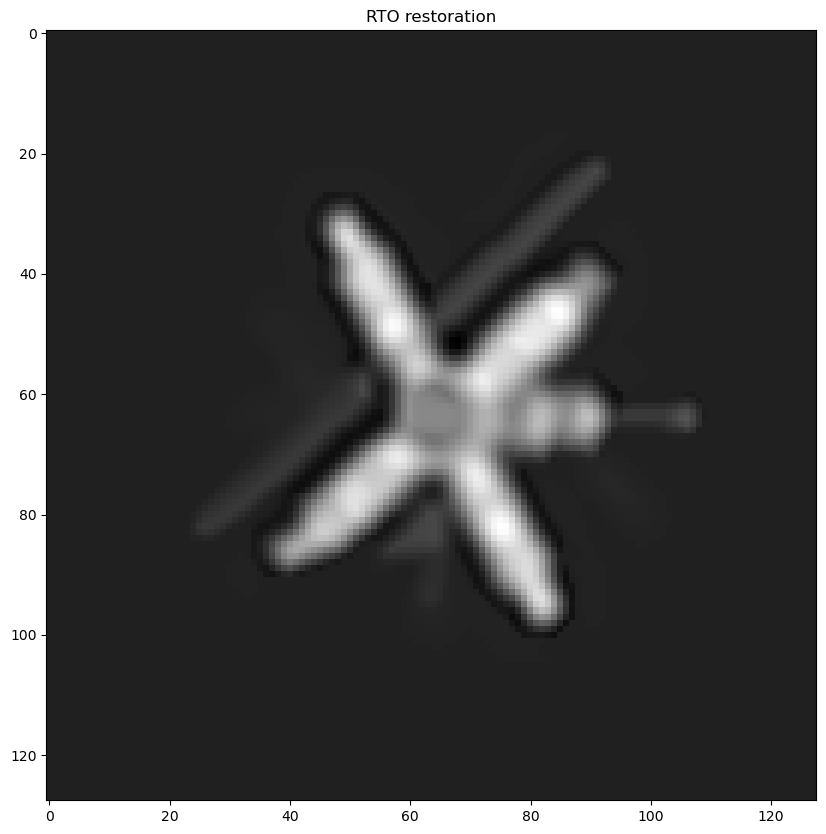

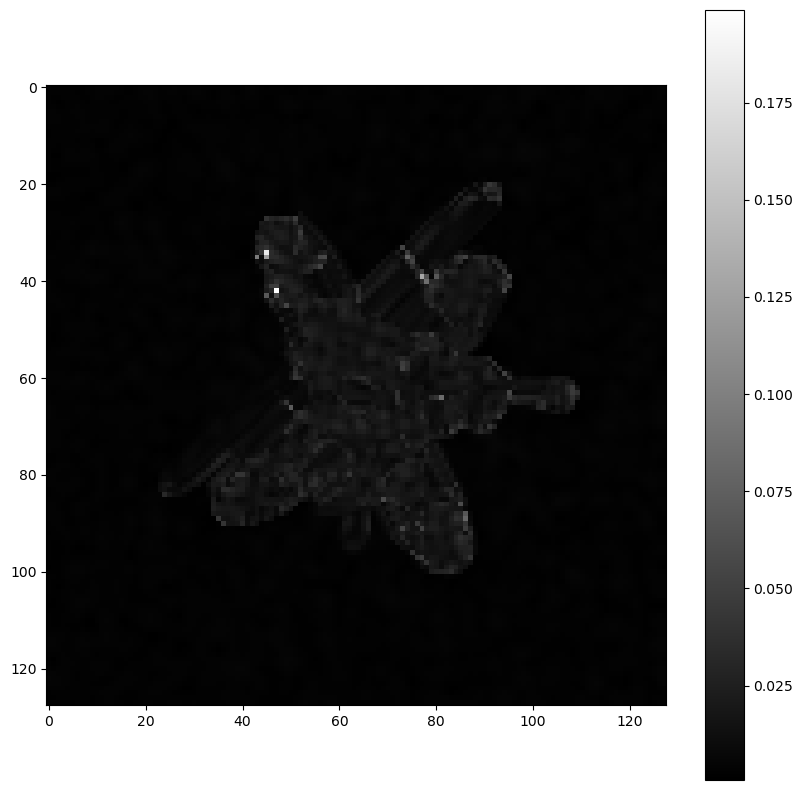

In [13]:
#%% PnP-GD parameters
scale=0.001
Ns=2000
Nrto=10
Samples_rto=[]

#%% RTO
for isample in range(Nrto):
    print(isample)
    y_pert = y_obs + 0.01*np.random.normal(0,1,info.exactData.shape)
    likelihood_pert=y(y=y_pert)
    # Init
    Xk=np.copy(y_obs)
    for i in range(Ns):
        Zk=np.random.normal(0,1,info.exactSolution.shape)
        Xk=Xk + scale*likelihood_pert.gradient(Xk) + scale*gradient_prior(Xk) #+ np.sqrt(2*scale)*Z
    Samples_rto.append(Xk)
    
mean_rto=np.mean(Samples_rto, axis=0)
mean_rto=np.reshape(mean_rto, (N,N))
plt.figure(figsize=(10, 10))
plt.imshow(mean_rto, cmap="gray")
plt.title('RTO restoration')

print("MSE(info.exactSolution, mean_rto) = ", mse(info.exactSolution, mean_rto.flatten()))

std_rto = np.std(Samples_rto, axis = 0)
plt.figure(figsize = (10, 10))
plt.imshow(np.reshape(std_rto, (N,N)), cmap="gray")
plt.colorbar()